# Step 0: Download data

In [ ]:
import numpy as np
import scipy as sp
import scipy.special as spsp
import matplotlib.pyplot as plt

# Fetch MNIST dataset
from sklearn.datasets import fetch_openml
mnist_data = fetch_openml('mnist_784')
mnist_data_x = (mnist_data['data']+0.5)/256.0
mnist_data_y = mnist_data['target'].astype('int8')

data_dim = mnist_data_x.shape[1]

## Split data into training and validation

In [ ]:
def display_mnist_digit(x,lbl=None):
  plt.imshow(x.reshape(28,28))
  plt.xticks([])
  plt.yticks([])
  if lbl is not None:
    plt.title(lbl)

def binary_mnist(c1,c0,N_train=200,N_val=200,seed=0):
  mask = np.logical_or(mnist_data_y == c1,mnist_data_y == c0)
  mnistbin_x = mnist_data_x[mask,:]
  mnistbin_y = mnist_data_y[mask] == c1 # label is true if digit is a 9, otherwise false

  if seed is not None:
    np.random.seed(seed)
  num_data = mnistbin_x.shape[0]
  rp = np.random.permutation(num_data)

  # Split the data into training and validation
  train_x = mnistbin_x[rp[:N_train]]
  train_y = mnistbin_y[rp[:N_train]]
  val_x = mnistbin_x[rp[N_train:(N_train+N_val)]]
  val_y = mnistbin_y[rp[N_train:(N_train+N_val)]]

  return train_x,train_y,val_x,val_y

mnistbin_train_x,mnistbin_train_y,mnistbin_val_x,mnistbin_val_y = binary_mnist(9,4)

# Step 1: Explore the data

**QUESTION**

49.0% of the training data is class True, corresponding to 98 data points


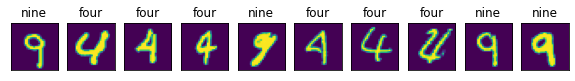

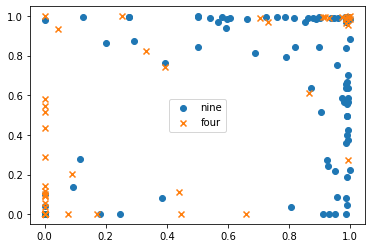

In [ ]:
# Print statistics
print('{}% of the training data is class True, corresponding to {} data points'.format(100*np.sum(mnistbin_train_y)/len(mnistbin_train_y),np.sum(mnistbin_train_y)))

# Visualize a few images
np.random.seed(0)
num_digits = 10
plt.figure(figsize=(10,5))
for i in range(num_digits):
  ind = np.random.randint(0,mnistbin_train_x.shape[0])
  plt.subplot(1,num_digits,i+1)
  display_mnist_digit(mnistbin_train_x[ind,:],
                      'nine' if mnistbin_train_y[ind] else 'four')

# Construct a scatter plot of two arbitrary dimensions
vis_dims = (211,238)
plt.figure()
plt.scatter(mnistbin_train_x[mnistbin_train_y==True][:,vis_dims[0]],
            mnistbin_train_x[mnistbin_train_y==True][:,vis_dims[1]],
            marker='o', label='nine')
plt.scatter(mnistbin_train_x[mnistbin_train_y==False][:,vis_dims[0]],
            mnistbin_train_x[mnistbin_train_y==False][:,vis_dims[1]],
            marker='x', label='four')
plt.legend()



# Step 2: Implement Logistic Regression

## Implement the sigmoid and log-sigmoid functions
Here we implement the sigmoid function to test that things are working properly.

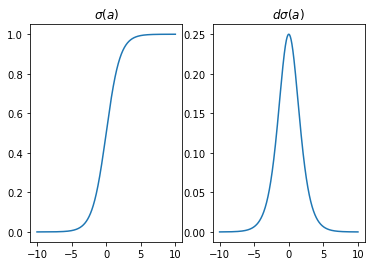

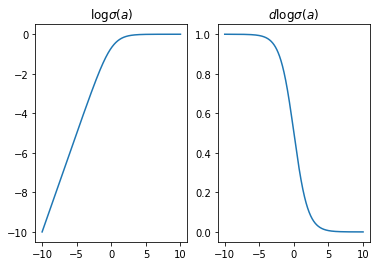

In [ ]:
def sigmoid(a):
  # Implement the sigmoid function 1/(1+exp(-a)) and its derivative
  #
  # Input: a - Vector of values
  # Output: s,ds
  #   s - Vector of sigmoid function evaluated at the values in a
  #  ds - Vector of the derivatives of the sigmoid evaluated at the values of a
  #
  # TODO: Implement this function.  Your implementation should be not just be a 
  # call to np.exp() wrapped around your implementation of log_sigmoid().
  # Rather, you should expand and simplify the expressions of the sigmoid
  # function and it's derivatives.
  #
  # NOTE: you may only use basic exp/log functions from numpy here.  Only
  # np.exp, np.log, np.log1p, np.log1m, along with basic arithmetic are allowed
  # in your implementation.
  s = 1/(1+np.exp(-a))
  ds = s*(1-s)

  return s, ds

def log_sigmoid(a):
  # Implement the log sigmoid function log(1/(1+exp(-a))) and its derivative
  #
  # Input: a - Vector of values
  # Output: logs,dlogs
  #   logs - Vector of log sigmoid function evaluated at the values in a
  #  dlogs - Vector of the derivatives of the logsigmoid evaluated at the values of a
  #
  # TODO: Implement this function.  Your implementation should be not just be a 
  # call to np.log() wrapped around your implementation of sigmoid().  Rather,
  # you should expand and simplify the expressions of the log sigmoid function
  # and it's derivatives.
  #
  # NOTE: you may only use basic exp/log functions from numpy here.  Only
  # np.exp, np.log, np.log1p, np.log1m, along with basic arithmetic are allowed
  # in your implementation.
  logs = np.log(1/(1+np.exp(-a)))
  dlogs = 1/(np.exp(a)+1)

  return logs, dlogs

def test_sigmoid_impl():
  # These are sanity checks, not exhaustive unit tests.  These may pass but you
  # may still have bugs.  However, if these don't pass you almost certainly have
  # bugs.

  avals = [-5,0,1]
  for a in avals:
    sa, dsa = sigmoid(a)
    lsa, dlsa = log_sigmoid(a)

    # VERY IMPORTANT: spsp.expit() should only be used for testing here.  You 
    # are expected to implement the sigmoid and logsigmoid directly in terms of
    # the numpy functions mentioned above.
    assert np.abs(sa - spsp.expit(a)) < 1e-8
    assert np.abs(lsa - np.log(sa)) < 1e-8
    assert np.abs(dlsa - (1.0/sa)*dsa) < 1e-8

    eps = 1e-10
    dsa_fd = (sigmoid(a+eps)[0] - sigmoid(a-eps)[0])/(2*eps)
    dlsa_fd = (log_sigmoid(a+eps)[0] - log_sigmoid(a-eps)[0])/(2*eps)
    assert np.abs(dsa-dsa_fd) < 1e-6
    assert np.abs(dlsa-dlsa_fd) < 1e-6

  ina = np.linspace(-10,10,1000)
  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(ina,sigmoid(ina)[0])
  plt.title('$\sigma(a)$')
  plt.subplot(1,2,2)
  plt.plot(ina,sigmoid(ina)[1])
  plt.title('$d \sigma(a)$')

  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(ina,log_sigmoid(ina)[0])
  plt.title('$\log \sigma(a)$')
  plt.subplot(1,2,2)
  plt.plot(ina,log_sigmoid(ina)[1])
  plt.title('$d \log \sigma(a)$')
  
test_sigmoid_impl()

## Implement logistic regression log probability and loss
Use the above sigmoid and log-sigmoid functions to implement logistic regression log probability and loss functions

In [ ]:
def logregr_logprob(x,theta):
  # Compute the log probility of the input belonging to class 1 for a
  # logistic regression model with parameters theta
  #
  # Input:
  #       x - a NxD array of N training examples with dimension D
  #   theta - a (D+1)x1 array of parameters.  The first D are the weights of
  #           each input dimenion (w).  The last entry is the bias (b).
  #
  # Output: lp
  #     lp - an Nx2 vector of log likelihoods of class 0 and class 1 given x
  #
  # TODO: Implement this function.  You should use your implementations of
  # the sigmoid and log_sigmoid functions above.
  b = theta[len(theta)-1]
  w = np.delete(theta, len(theta)-1)
  a = np.matmul(w,x.T)+b
  log_p1 = log_sigmoid(a)[0]
  log_p0 = np.log(sigmoid(np.negative(a))[0])
  lp = np.vstack((log_p0, log_p1)).T

  return lp


def logregr_loss(x,y,theta,lmbda=0):
  # Compute the negative log likelihood of a set of training samples for a
  # logistic regression model with regularization parameter lambda
  #
  # Input:
  #       x - a NxD array of N training examples with dimension D
  #       y - a Nx1 array with true/false (1/0) labels for each training example
  #   theta - a (D+1)x1 array of parameters.  The first D are the weights of
  #           each input dimenion (w).  The last entry is the bias (b).
  #  lambda - a scalar indicating the strength of the regularization
  #
  # Output: loss, grad, acc
  #     loss - scalar,  negative log likelihood of training data
  #    grad - a (D+1)x1 vector with the gradient gradient of negative log
  #         - likelihood with respect to theta
  #     acc - scalar, accuracy of the currect value of theta on the data
  #           computed by counting what fraction of times the correct class is 
  #           given a probability > 0.5 (or log probability > log(0.5)).
  #
  # TODO: Implement this function.  You should use your implementations of
  # the sigmoid and log_sigmoid functions above.
  #−[y logσ(w· x+b) + (1−y)log(1−σ(w· x+b))]
  b = theta[len(theta)-1]
  w = np.delete(theta, len(theta)-1)
  a = np.matmul(w,x.T)+b

  loss = -np.sum(y*log_sigmoid(a)[0] + (1-y)*log_sigmoid(-a)[0]) + (lmbda/2)*np.matmul(w,w.T)
  dw = lmbda*w - np.dot((y-sigmoid(a)[0]),x)
  db = - np.sum((y-sigmoid(a)[0]))
  #sum = np.zeros(len(theta)-1) 
  #for i in range(len(y)):
    #sum -= (y[i]-sigmoid(np.matmul(x[i],np.transpose(w))+b)[0])*x[i]
  #dw = -(lmbda*w - sum)
  #db = - np.sum((y-sigmoid(a)[0]))
  dloss = np.append(dw,db)

  #b = theta[len(theta)-1]
  #w = np.delete(theta,len(theta)-1)
  #print(w)
  lp_x =  logregr_logprob(x,theta)
  #wtw = np.matrix(w)*np.matrix(w).T
  #loss = 0
  #for i in range(len(y)):
    #loss += -(y[i]*lp_x[i][1] + (1-y[i])*lp_x[i][0]) + lmbda/2*wtw


  #loss = (-(y*np.log(1/(1+np.exp(-a)))+(1-y)*np.log(1/(1+np.exp(a))))).sum()
  #original dloss
  #dloss_w1 = np
  #for i in range(len(y)):
    #a = np.matrix(w)*np.matrix(x[i]).T+b
    #dloss_w1 = (y[i]-sigmoid(a)[0])*x[i]
  #dloss_w = lmbda*w - dloss_w1
  
  #dloss_b = 0
  #for i in range(len(y)):
    #a = np.matrix(w)*np.matrix(x[i]).T+b
    #dloss_b += -(y[i]-sigmoid(a)[0])
  
  #dloss = np.append(dloss_w, dloss_b,axis = 1).T#np.matrix(np.concatenate([dloss_w.reshape(4,1),dloss_b])).T #np.concatenate([dloss_w,dloss_b])
  
  #dloss = np.empty_like(theta)
  #for i in range(len(y)):
    #dloss += y[i]*theta - np.log(1+np.exp(theta))

  #dloss = dloss.T 
  count = 0

  count = np.sum(lp_x[:, 0][y == False] >  np.log(0.5)) + np.sum(lp_x[:, 1][y == True] >  np.log(0.5))
  acc = count/len(y)
  
  return loss, dloss, acc

def test_logregr_logprob():
  # These are sanity checks, not exhaustive unit tests.  These may pass but you
  # may still have bugs.  However, if these don't pass you almost certainly have
  # bugs.
  # Predicted probabilities in this case should be [0.5,0.5]
  assert np.all(np.abs(np.log(0.5) - logregr_logprob(np.zeros((1,1)), np.zeros((2)))) < 1e-8)
  # Predicted probabilities in this case should be approximately [0,1]
  assert np.all(np.abs(np.array([-100,0]) - logregr_logprob(np.zeros((1,1)), np.array([0,100]))[0]) < 1e-8)
  # Predicted probabilities in this case should be approximately [1,0]
  assert np.all(np.abs(np.array([0,-100]) - logregr_logprob(np.zeros((1,1)), np.array([0,-100]))[0]) < 1e-8)

  np.random.seed(0)
  test_N = 10
  test_D = 4
  test_x = np.random.randn(test_N,test_D)
  test_y = np.random.rand(test_N) > 0.5
  test_theta = np.concatenate((np.random.randn(test_D),np.random.randn(1)),axis=0)
  #print(test_theta)
  test_loss, test_dloss, _ = logregr_loss(test_x,test_y,test_theta)
  # loss should be negative sum of logprob
  lps = logregr_logprob(test_x,test_theta)
  assert np.abs(-np.sum((1-test_y)*lps[:,0] + test_y*lps[:,1]) - test_loss) < 1e-8
  
  # central difference approximation of the gradient should be fairly accurate
  test_loss, test_dloss, _ = logregr_loss(test_x,test_y,test_theta,lmbda=1)
  eps = 1e-8
  test_dloss_fd = np.empty_like(test_dloss)
  for i in range(test_theta.shape[0]):
    test_theta0 = np.copy(test_theta)
    test_theta0[i] -= eps
    test_theta1 = np.copy(test_theta)
    test_theta1[i] += eps
    test_loss0 = logregr_loss(test_x,test_y,test_theta0,lmbda=1)[0]
    test_loss1 = logregr_loss(test_x,test_y,test_theta1,lmbda=1)[0]
    test_dloss_fd[i] = (test_loss1 - test_loss0)/(2*eps)
  
  assert np.allclose(test_dloss,test_dloss_fd)

test_logregr_logprob()

## Implement Gradient Descent for logistic regression

In [ ]:
def fit_logregr(train_x,train_y,val_x,val_y,lmbda,quiet=True):

  N,D = train_x.shape

  theta = 0.1*np.random.randn(D+1)

  loss, dloss, acc = logregr_loss(train_x,train_y,theta,lmbda)
  loss_val, _, acc_val = logregr_loss(val_x,val_y,theta,lmbda)

  losss_train = [loss]
  dlosss_train = [(dloss**2).sum()]
  accs_train = [acc]
  losss_val = [loss_val]
  accs_val = [acc_val]
  step_size = 1e-6
  for it in range(300):
    if not quiet and it % 10 == 0:
      print('it {}: loss = {:.4}, acc = {:.2}, ||dloss||^2 = {:.4}, step_size = {:.4}'.format(it, loss, acc, (dloss**2).sum(), step_size))
      print('       loss_val = {:.4}, acc_val = {:.2}'.format(loss_val, acc_val))

    # TODO: Use the logregr_loss function to implement this portion of code.
    # You should aim for efficiency of your implementation here and avoid extra
    # calls to logregr_loss for values that have already been computed.
    step_size = 1.5*step_size
    
    while(logregr_loss(train_x,train_y,theta - step_size*dloss,lmbda)[0] >= loss):
      step_size = 1/2 * step_size
    
    theta = theta - step_size*dloss
    
    loss, dloss, acc = logregr_loss(train_x,train_y,theta,lmbda)
    loss_val, _, acc_val = logregr_loss(val_x,val_y,theta,lmbda)
    # NOTE: by this point loss, dloss, acc, loss_val, acc_val should all be 
    # evaluated with the new value of theta.  You shouldn't need to modify code
    # beyond this point

    # Record the loss and accuracy for the train and val data at each iteration
    losss_train.append(loss)
    dlosss_train.append((dloss**2).sum())
    losss_val.append(loss_val)
    accs_train.append(acc)
    accs_val.append(acc_val)
  if not quiet:
    print('FINAL: loss = {:.4}, acc = {:.2}, ||dloss||^2 = {:.4}, step_size = {:.4}'.format(loss, acc, (dloss**2).sum(), step_size))
    print('       loss_val = {:.4}, acc_val = {:.2}'.format(loss_val, acc_val))

  lrmodel = {'logprob':logregr_logprob,
             'theta':theta,
             'training_stats':{'loss_train':losss_train,
                               'dloss_train':dlosss_train,
                               'acc_train':accs_train,
                               'loss_val':losss_val,
                               'acc_val':accs_val}}
  return lrmodel


In [ ]:
def plot_logregr_training(lrmodel):
  # TODO:
  # Produce two plots. In the first plot, you should plot loss_train and
  # loss_val on the y axis with iteration number on the x axis.  Each curve
  # should be a different colour and be labelled and the legend displayed.
  #
  # The second plot should plot acc_train and acc_val on the y axis and
  # iteration number on the x axis.  As above, each curve should be a different
  # colour and be labelled and the legend displayed.
  # 
  # Both plots should have a title.  Also, note that you may need to adjust the
  # range of the plots (e.g., using plt.ylim()) in order to answer some of the 
  # questions.

  # for implementing plot_logregr_training you should put iteration on the x axis (i.e., the horizontal axis) and loss/accuracy values on the y axis (i.e., on the vertical axis). 
  
  plt.plot(lrmodel['training_stats']['loss_train'],'b', label = "Train_loss")
  plt.plot(lrmodel['training_stats']['loss_val'], 'r', label = "Validation_loss")
  plt.title("Train_loss vs Validation_loss")
  plt.xlabel("Number of iteration")
  plt.ylabel("Loss")
  plt.legend(loc = "best")
  plt.show()
  plt.plot(lrmodel['training_stats']['acc_train'],'b', label = "Training_accuracy")
  plt.plot(lrmodel['training_stats']['acc_val'], 'r', label = "Validation_accuracy")
  plt.title("Training_accuracy vs acc_val")
  plt.xlabel("Number of Validation_accuracy")
  plt.ylabel("Accuracy")
  plt.legend(loc = "best")
  plt.show()
  



**QUESTION 2**

it 0: loss = 165.9, acc = 0.51, ||dloss||^2 = 7.014e+04, step_size = 1e-06
       loss_val = 161.7, acc_val = 0.49
it 10: loss = 156.0, acc = 0.52, ||dloss||^2 = 4.589e+04, step_size = 5.767e-05
       loss_val = 150.9, acc_val = 0.49
it 20: loss = 70.18, acc = 0.91, ||dloss||^2 = 3.42e+03, step_size = 0.003325
       loss_val = 73.03, acc_val = 0.88
it 30: loss = 39.91, acc = 0.95, ||dloss||^2 = 1.003e+03, step_size = 0.001498
       loss_val = 47.19, acc_val = 0.92
it 40: loss = 29.9, acc = 0.96, ||dloss||^2 = 1.971e+03, step_size = 0.0027
       loss_val = 39.93, acc_val = 0.92
it 50: loss = 22.82, acc = 0.97, ||dloss||^2 = 1.124e+03, step_size = 0.004865
       loss_val = 35.08, acc_val = 0.93
it 60: loss = 17.39, acc = 0.98, ||dloss||^2 = 127.1, step_size = 0.004383
       loss_val = 31.05, acc_val = 0.94
it 70: loss = 13.59, acc = 0.99, ||dloss||^2 = 80.71, step_size = 0.003949
       loss_val = 29.4, acc_val = 0.94
it 80: loss = 10.96, acc = 0.99, ||dloss||^2 = 83.81, step_size 

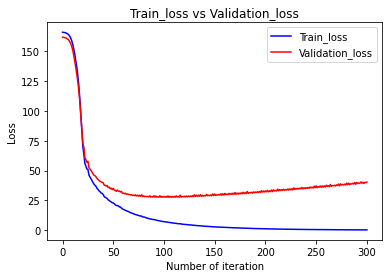

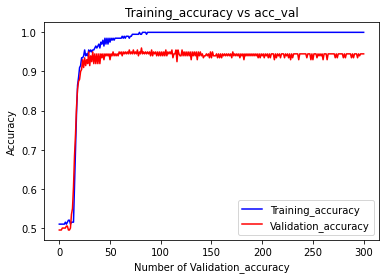

In [ ]:
lrmodel_noregr = fit_logregr(mnistbin_train_x,mnistbin_train_y,
                             mnistbin_val_x,mnistbin_val_y,0,quiet=False)
plot_logregr_training(lrmodel_noregr)

**QUESTION 3**

it 0: loss = 183.2, acc = 0.55, ||dloss||^2 = 3.08e+04, step_size = 1e-06
       loss_val = 188.6, acc_val = 0.49
it 10: loss = 178.7, acc = 0.55, ||dloss||^2 = 2.322e+04, step_size = 5.767e-05
       loss_val = 184.1, acc_val = 0.52
it 20: loss = 103.8, acc = 0.91, ||dloss||^2 = 3.003e+03, step_size = 0.003325
       loss_val = 111.0, acc_val = 0.89
it 30: loss = 75.3, acc = 0.95, ||dloss||^2 = 4.671e+03, step_size = 0.002996
       loss_val = 83.09, acc_val = 0.93
it 40: loss = 63.65, acc = 0.97, ||dloss||^2 = 432.3, step_size = 0.00135
       loss_val = 72.57, acc_val = 0.94
it 50: loss = 58.03, acc = 0.97, ||dloss||^2 = 498.8, step_size = 0.002432
       loss_val = 67.56, acc_val = 0.93
it 60: loss = 54.73, acc = 0.97, ||dloss||^2 = 118.5, step_size = 0.002192
       loss_val = 64.95, acc_val = 0.94
it 70: loss = 52.73, acc = 0.98, ||dloss||^2 = 100.2, step_size = 0.001975
       loss_val = 63.32, acc_val = 0.94
it 80: loss = 51.64, acc = 0.98, ||dloss||^2 = 61.98, step_size = 0.00

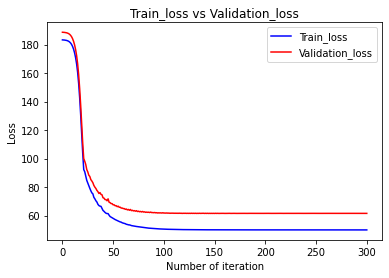

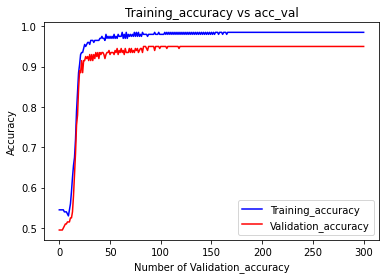

In [ ]:
lrmodel_regr = fit_logregr(mnistbin_train_x,mnistbin_train_y,
                           mnistbin_val_x,mnistbin_val_y,10.0,quiet=False)
plot_logregr_training(lrmodel_regr)

## Investigate the models

Visualize the weights of the regularized and unregularized logistic regression model using the `display_mnist_digit` function.

**QUESTION 4**

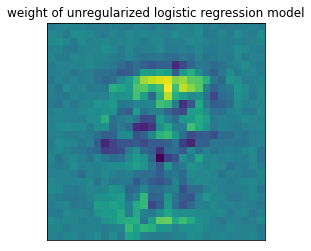

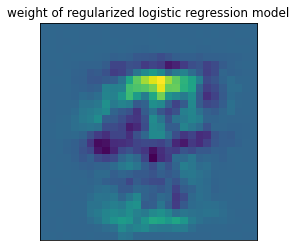

In [ ]:
# TODO: show images representing the weights of the two classes
w_noreg = lrmodel_noregr['theta'][:-1]
plt.figure(1)
plt.title("weight of unregularized logistic regression model")
display_mnist_digit(w_noreg)
w_reg =  lrmodel_regr['theta'][:-1]
plt.figure(2)
plt.title("weight of regularized logistic regression model")
display_mnist_digit(w_reg)

Find and visualize some interesting examples from the validation set.

**QUESTION 5** and **QUESTION 6**

for without regularization:
highest probability images without regularization
(the first two lines are the probabilities and the third line is the correct class)


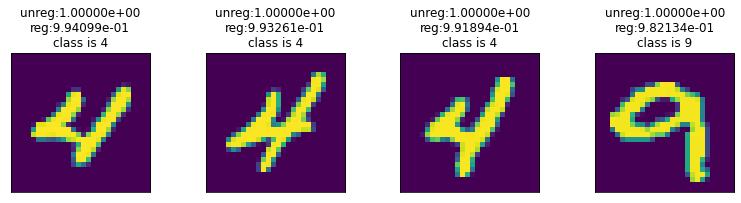

lowest probability images without regularization
(the first two lines are the probabilities and the third line is the correct class)


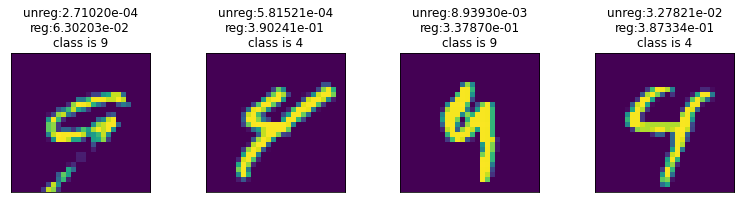

highest probability images with regularization
(the first two lines are the probabilities and the third line is the correct class)


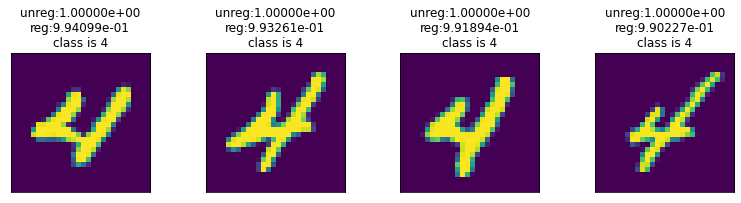

lowest probability images with regularization
(the first two lines are the probabilities and the third line is the correct class)


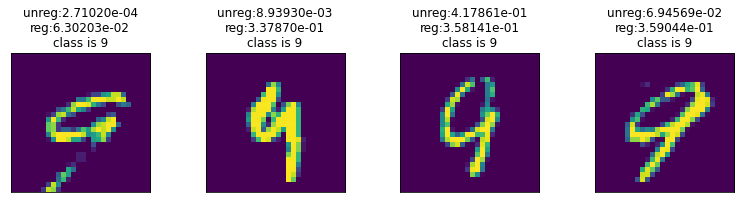

probability cloest to 0.5 images without regularization
(the first two lines are the probabilities and the third line is the correct class)


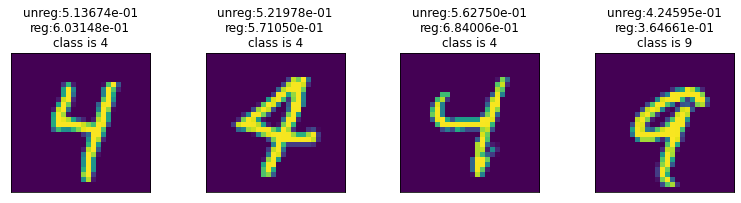

probability cloest to 0.5 images with regularization
(the first two lines are the probabilities and the third line is the correct class)


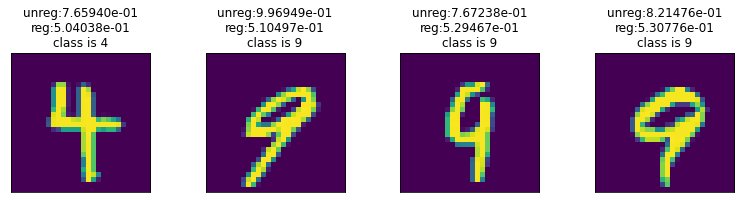

In [ ]:
# Evaluate the log probabilities under the model for each class of the
# validation data.
val_noregr_lps = logregr_logprob(mnistbin_val_x,lrmodel_noregr['theta'])

val_regr_lps = logregr_logprob(mnistbin_val_x,lrmodel_regr['theta'])

# TODO: Sort examples in the validation set according to probability of the
# correct class.  Then show the four images with the lowest probability of the
# correct class and the four images with the highest probabilities of the
# correct class.  For each image include in it's title the probability of the
# correct class with and without regularization and which is the correct class,
# 4 or 9.
#you would have 4 plots, highest and lowest correct probability for the regularized and unregularized models
new_noreg = np.zeros((val_noregr_lps.shape[0],3))
new_reg = np.zeros((val_regr_lps.shape[0],3))
n = val_noregr_lps.shape[0]
for i in range(n):
  new_noreg[i][0] = i 
  new_reg[i][0] = i
  if mnistbin_val_y[i] == False :
    new_noreg[i][1] = val_noregr_lps[i][0]
    new_noreg[i][2] = val_regr_lps[i][0]
    new_reg[i][1] = val_regr_lps[i][0]
    new_reg[i][2] = val_noregr_lps[i][0]

  else:
    new_noreg[i][1] = val_noregr_lps[i][1]
    new_noreg[i][2] = val_regr_lps[i][1]
    new_reg[i][1] = val_regr_lps[i][1]
    new_reg[i][2] = val_noregr_lps[i][1]

sorted_noreg = new_noreg[new_noreg[:, 1].argsort()] 
sorted_reg = new_reg[new_reg[:, 1].argsort()] 

print("for without regularization:")
print('highest probability images without regularization' + '\n' + '(the first two lines are the probabilities and the third line is the correct class)')
for i in range(4):
  index = int(sorted_noreg[len(sorted_noreg)-i-1][0])
  ax = plt.subplot(1,4,i+1)
  plt.subplots_adjust(left=0.125, bottom=0.1, right=1.8, top=1.8, wspace=0.4, hspace=0.4)

  un_prob = np.exp(sorted_noreg[len(sorted_noreg)-i-1][1])
  reg_prob = np.exp(sorted_noreg[len(sorted_noreg)-i-1][2])
  display_mnist_digit(mnistbin_val_x[index], 'unreg:'+ format(un_prob, '.5e') +'\n'+'reg:'+ format(reg_prob, '.5e') +'\n' 
                      + ('class is 4' if mnistbin_val_y[index] == 0 else 'class is 9'))

plt.show()

print('lowest probability images without regularization' + '\n' + '(the first two lines are the probabilities and the third line is the correct class)')
for i in range(4):
  index = int(sorted_noreg[i][0])
  ax = plt.subplot(1,4,i+1)
  plt.subplots_adjust(left=0.125, bottom=0.1, right=1.8, top=1.8, wspace=0.4, hspace=0.4)

  un_prob = np.exp(sorted_noreg[i][1])
  reg_prob = np.exp(sorted_noreg[i][2])
  display_mnist_digit(mnistbin_val_x[index], 'unreg:'+ format(un_prob, '.5e') +'\n'+'reg:'+ format(reg_prob, '.5e') +'\n' 
                      + ('class is 4' if mnistbin_val_y[index] == 0 else 'class is 9'))

plt.show()

print('highest probability images with regularization' + '\n' + '(the first two lines are the probabilities and the third line is the correct class)')
for i in range(4):
  index = int(sorted_reg[len(sorted_reg)-i-1][0])
  ax = plt.subplot(1,4,i+1)
  plt.subplots_adjust(left=0.125, bottom=0.1, right=1.8, top=1.8, wspace=0.4, hspace=0.4)

  un_prob = np.exp(sorted_reg[len(sorted_reg)-i-1][2])
  reg_prob = np.exp(sorted_reg[len(sorted_reg)-i-1][1])
  display_mnist_digit(mnistbin_val_x[index], 'unreg:'+ format(un_prob, '.5e') +'\n'+'reg:'+ format(reg_prob, '.5e') +'\n' 
                      + ('class is 4' if mnistbin_val_y[index] == 0 else 'class is 9'))

plt.show()

print('lowest probability images with regularization' + '\n' + '(the first two lines are the probabilities and the third line is the correct class)')
for i in range(4):
  index = int(sorted_reg[i][0])
  ax = plt.subplot(1,4,i+1)
  plt.subplots_adjust(left=0.125, bottom=0.1, right=1.8, top=1.8, wspace=0.4, hspace=0.4)

  un_prob = np.exp(sorted_reg[i][2])
  reg_prob = np.exp(sorted_reg[i][1])
  display_mnist_digit(mnistbin_val_x[index], 'unreg:'+ format(un_prob, '.5e') +'\n'+'reg:'+ format(reg_prob, '.5e') +'\n' 
                      + ('class is 4' if mnistbin_val_y[index] == 0 else 'class is 9'))

plt.show()
# TODO: Sort examples in the validation set according to the absolute difference
# between the probability of the correct class and 0.5.  Then show the four
# images whose probability of correct class is closest to 0.5.  For each image
# include in it's title the probability of the correct class with and without
# regularization and which is the correct class, 4 or 9.
new_val_noregr_lps = np.abs(np.exp(val_noregr_lps) - 0.5)
new_val_regr_lps = np.abs(np.exp(val_regr_lps) - 0.5)

new_noreg = np.zeros((new_val_noregr_lps.shape[0],4))
new_reg = np.zeros((new_val_regr_lps.shape[0],4))
n = val_noregr_lps.shape[0]
for i in range(n):
  new_noreg[i][0] = i 
  new_reg[i][0] = i
  if mnistbin_val_y[i] == False :
    new_noreg[i][1] = new_val_noregr_lps[i][0]
    new_noreg[i][2] = np.exp(val_noregr_lps[i][0])
    new_noreg[i][3] = np.exp(val_regr_lps[i][0])
    new_reg[i][1] = new_val_regr_lps[i][0]
    new_reg[i][2] = np.exp(val_noregr_lps[i][0])
    new_reg[i][3] = np.exp(val_regr_lps[i][0])

  else:
    new_noreg[i][1] = new_val_noregr_lps[i][1]
    new_noreg[i][2] = np.exp(val_noregr_lps[i][1])
    new_noreg[i][3] = np.exp(val_regr_lps[i][1])
    new_reg[i][1] = new_val_regr_lps[i][1]
    new_reg[i][2] = np.exp(val_noregr_lps[i][1])
    new_reg[i][3] = np.exp(val_regr_lps[i][1])

sorted_noreg = new_noreg[new_noreg[:, 1].argsort()] 
sorted_reg = new_reg[new_reg[:, 1].argsort()] 



print('probability cloest to 0.5 images without regularization' + '\n' + '(the first two lines are the probabilities and the third line is the correct class)')
for i in range(4):
  index = int(sorted_noreg[i][0])
  ax = plt.subplot(1,4,i+1)
  plt.subplots_adjust(left=0.125, bottom=0.1, right=1.8, top=1.8, wspace=0.4, hspace=0.4)
  un_prob = sorted_noreg[i][2]
  reg_prob = sorted_noreg[i][3]
  display_mnist_digit(mnistbin_val_x[index], 'unreg:'+ format(un_prob, '.5e') +'\n'+'reg:'+ format(reg_prob, '.5e') +'\n' 
                      + ('class is 4' if mnistbin_val_y[index] == 0 else 'class is 9'))
plt.show()
print('probability cloest to 0.5 images with regularization' + '\n' + '(the first two lines are the probabilities and the third line is the correct class)')
for i in range(4):
  index = int(sorted_reg[i][0])
  ax = plt.subplot(1,4,i+1)
  plt.subplots_adjust(left=0.125, bottom=0.1, right=1.8, top=1.8, wspace=0.4, hspace=0.4)
  un_prob = sorted_reg[i][2]
  reg_prob = sorted_reg[i][3]
  display_mnist_digit(mnistbin_val_x[index], 'unreg:'+ format(un_prob, '.5e') +'\n'+'reg:'+ format(reg_prob, '.5e') +'\n' 
                      + ('class is 4' if mnistbin_val_y[index] == 0 else 'class is 9'))
plt.show()

# Step 3: Run LR again with a different set of digit classes
This time, use the digits 0 and 1.

**QUESTION 7**

it 0: loss = 326.9, acc = 0.47, ||dloss||^2 = 4.454e+05, step_size = 1e-06
       loss_val = 132.6, acc_val = 0.45
it 10: loss = 261.5, acc = 0.48, ||dloss||^2 = 3.132e+05, step_size = 5.767e-05
       loss_val = 112.0, acc_val = 0.49
it 20: loss = 53.6, acc = 0.99, ||dloss||^2 = 1.276e+03, step_size = 0.003325
       loss_val = 43.41, acc_val = 0.98
it 30: loss = 16.68, acc = 1.0, ||dloss||^2 = 1.531, step_size = 0.005992
       loss_val = 12.22, acc_val = 1.0
it 40: loss = 16.57, acc = 1.0, ||dloss||^2 = 7.286, step_size = 0.0108
       loss_val = 12.1, acc_val = 1.0
it 50: loss = 16.47, acc = 1.0, ||dloss||^2 = 3.042, step_size = 0.009729
       loss_val = 12.02, acc_val = 1.0
it 60: loss = 16.39, acc = 1.0, ||dloss||^2 = 2.614, step_size = 0.01753
       loss_val = 11.96, acc_val = 1.0
it 70: loss = 16.32, acc = 1.0, ||dloss||^2 = 1.064, step_size = 0.007899
       loss_val = 11.91, acc_val = 1.0
it 80: loss = 16.27, acc = 1.0, ||dloss||^2 = 3.147, step_size = 0.01423
       loss_v

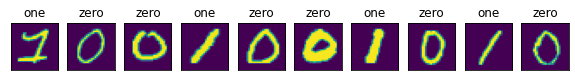

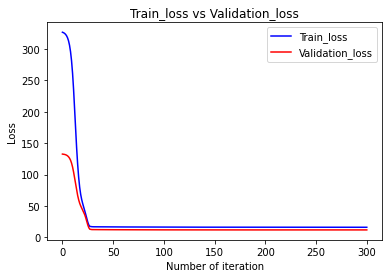

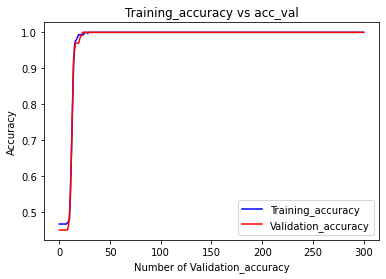

sample image
(the first two lines are the probabilities and the third line is the correct class)


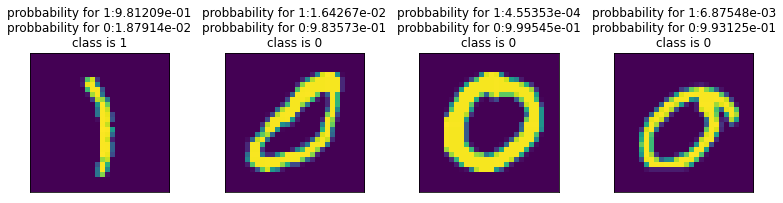

In [ ]:
# TODO: Use the `binary_mnist` function to partition the dataset differently and
# follow the same basic steps as above.  First, visualize a few images from the
# new dataset to get a sense.  Then run regularized logistic regression on this
# new dataset, visualize the training and validation performance curves and
# print results.  Finally, visualize a few sample images and their predicted
# class probabilities and true labels.
mnistbin_train_x1,mnistbin_train_y1,mnistbin_val_x1,mnistbin_val_y1 = binary_mnist(1,0,N_train=300,N_val=100,seed=0)


# Visualize a few images
np.random.seed(0)
num_digits = 10
plt.figure(figsize=(10,5))
for i in range(num_digits):
  ind = np.random.randint(0,mnistbin_train_x1.shape[0])
  plt.subplot(1,num_digits,i+1)
  display_mnist_digit(mnistbin_train_x1[ind,:],
                      'one' if mnistbin_train_y1[ind] else 'zero')

# Construct a scatter plot of two arbitrary dimensions
plt.figure()

lrmodel_regr1 = fit_logregr(mnistbin_train_x1,mnistbin_train_y1, mnistbin_val_x1,mnistbin_val_y1,10.0,quiet=False)

plot_logregr_training(lrmodel_regr1)

val_regr_lps1 = logregr_logprob(mnistbin_val_x1,lrmodel_regr1['theta'])

print('sample image' + '\n' + '(the first two lines are the probabilities and the third line is the correct class)')
for i in range(4):
  ax = plt.subplot(1,4,i+1)
  plt.subplots_adjust(left=0.125, bottom=0.1, right=1.8, top=1.8, wspace=0.4, hspace=0.4)

  prob_11 = np.exp(val_regr_lps1[i][1])
  prob_01 = np.exp(val_regr_lps1[i][0])
  display_mnist_digit(mnistbin_val_x1[i], 'probbability for 1:'+ format(prob_11, '.5e') +'\n'+'probbability for 0:'+ format(prob_01, '.5e') +'\n' 
                      + ('class is 0' if mnistbin_val_y1[i] == 0 else 'class is 1'))

plt.show()